In [1]:
from sklearn.preprocessing import LabelEncoder
from preprocessor import Preprocessor

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joypy
from ast import literal_eval
from pandas.api.types import is_datetime64_any_dtype
from tqdm import tqdm

import warnings
import pickle

# Data Preprocessing

In [2]:
parquet = r'./preprocessed.parquet.gzip'
preprocessor = Preprocessor(parquet_path=parquet)
df = preprocessor.get_dataframe()
empties = df['query_template'] == ''
print(f"Removing {sum(empties)} empty query template values.")
df = df[:][~empties]
df.shape

Removing 38 empty query template values.


(759272, 5)

In [3]:
groups = [(qt, gdf) for qt, gdf in df.groupby('query_template')]

selected_group = 25
query_template, gdf = groups[selected_group]
print(query_template)
display(gdf)

SELECT NO_O_ID FROM new_order WHERE NO_D_ID = $1 AND NO_W_ID = $2 ORDER BY NO_O_ID ASC LIMIT $3


,query_template,query_params,session_line_num,virtual_transaction_id,transaction_id
log_time,,,,,
2022-03-08 11:29:38.190000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('1', '1', 1)",480267,3/16698,0
2022-03-08 11:29:38.191000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('2', '1', 1)",480274,3/16698,56564
2022-03-08 11:29:38.191000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('3', '1', 1)",480281,3/16698,56564
2022-03-08 11:29:38.192000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('4', '1', 1)",480288,3/16698,56564
2022-03-08 11:29:38.192000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('5', '1', 1)",480295,3/16698,56564
...,...,...,...,...,...
2022-03-08 11:29:41.836000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('6', '1', 1)",529249,3/18392,58124
2022-03-08 11:29:41.836000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('7', '1', 1)",529256,3/18392,58124
2022-03-08 11:29:41.837000-05:00,SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...,"('8', '1', 1)",529263,3/18392,58124


In [11]:
# Extract parameters columns. Only deal with numerical or date parameters

# {key=template, value=params_dataframe}
query_to_df_original_map = {}
# {key=template, value=params_dataframe}
query_to_df_normalized_map = {}
# {key=template, value=[p1_dtype, p2_dtype, ...]}
query_to_dtype_map = {}
# {key=template, value=[(p1_mean, p1_var), (p2_mean, p2_var), ...]}
query_to_stats = {}

with warnings.catch_warnings():
  for index, (query_template, tdf) in enumerate(tqdm(df.groupby('query_template'))):

    # print(f"******************************************")
    # print(index, query_template)

    # Skip query templates with no parameters ex. BEGIN
    if tdf['query_params'][0] == ():
        continue 
    
    # Extract param columns and strip off the quotation marks
    tdfp = tdf['query_params'].apply(pd.Series)
    tdfp = tdfp.apply(lambda col: col.str.strip("\"'"))

    # Make a copy of tdfp to store normalized version
    normalized_tdfp = tdfp.copy(deep=True)

    dtypes = []
    stats = []
    for j, col in enumerate(tdfp):
        try:
            tdfp[col] = pd.to_numeric(tdfp[col], errors='raise')
            normalized_tdfp[col] = pd.to_numeric(normalized_tdfp[col], errors='raise')
            dtypes.append("numerical")
        except:
            try:
                tdfp[col] = pd.to_datetime(tdfp[col], errors='raise')
                normalized_tdfp[col] = pd.to_datetime(normalized_tdfp[col], errors='raise')
                dtypes.append("date")
            except:
                # TODO: Right now we drop non date/numerical columns. Want to handle string columns later
                dtypes.append("string")
                pass

        # Compute mean/var and standardize the column
        if dtypes[-1] != "string":
            # print(f"param {j}, {dtypes[-1]}")
            mean = tdfp[col].mean()
            std = tdfp[col].std()
            # print(mean, std)
            # print(tdfp[col])
            if std != 0:
                normalized_tdfp[col] = (normalized_tdfp[col]-mean)/std
            else:
                normalized_tdfp[col] = (normalized_tdfp[col]-mean)
            stats.append((mean, std))
        else:
            stats.append(None)
    tdfp = tdfp.convert_dtypes()

    # Store df, dtype, and stats for this template
    query_to_df_original_map[query_template] = tdfp
    query_to_df_normalized_map[query_template] = normalized_tdfp
    query_to_dtype_map[query_template] = dtypes
    query_to_stats[query_template] = stats

100%|██████████| 43/43 [01:48<00:00,  2.53s/it]


In [12]:
import pickle

# Save the dictionaries
with open('./data/query_to_df_original_map.pickle', 'wb') as f:
    pickle.dump(query_to_df_original_map, f)

with open('./data/query_to_df_normalized_map.pickle', 'wb') as f:
    pickle.dump(query_to_df_normalized_map, f)

with open('./data/query_to_dtype_map.pickle', 'wb') as f:
    pickle.dump(query_to_dtype_map, f)

with open('./data/query_to_stats.pickle', 'wb') as f:
    pickle.dump(query_to_stats, f)

In [34]:
# with open('./data/query_to_df_map.pickle', 'rb') as f:
#   temp = pickle.load(f)
# temp["DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"].head()

In [10]:
# for qt in query_to_df_map.keys():
#   print(qt)
#   print(query_to_df_original_map[qt].head())
#   print(query_to_df_normalized_map[qt].head())
#   print(query_to_dtype_map[qt],query_to_stats[qt])
#   print("*********************************\n")
#   break

DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3
                                     0  1  2
log_time                                    
2022-03-08 11:29:38.190000-05:00  3830  1  1
2022-03-08 11:29:38.191000-05:00  3830  2  1
2022-03-08 11:29:38.191000-05:00  3830  3  1
2022-03-08 11:29:38.192000-05:00  3830  4  1
2022-03-08 11:29:38.192000-05:00  3830  5  1
                                        0         1    2
log_time                                                
2022-03-08 11:29:38.190000-05:00  0.43997 -1.566625  0.0
2022-03-08 11:29:38.191000-05:00  0.43997 -1.218486  0.0
2022-03-08 11:29:38.191000-05:00  0.43997 -0.870347  0.0
2022-03-08 11:29:38.192000-05:00  0.43997 -0.522208  0.0
2022-03-08 11:29:38.192000-05:00  0.43997 -0.174069  0.0
['numerical', 'numerical', 'numerical'] [(3696.0, 304.5665649610596), (5.5, 2.8724174600239913), (1.0, 0.0)]
*********************************



In [14]:
def graph_query(index, query_to_df_map):
    qt = list(query_to_df_map.keys())[index]
    gdft = query_to_df_map[qt]
    print("Query:", qt)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, col in enumerate(gdft):
            meow = gdft[col].to_frame()
            try:
                joypy.joyplot(meow.groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True)
                print(f"PARAM ${i+1}")
                plt.show()
            except:
                pass


Query: DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3
PARAM $1


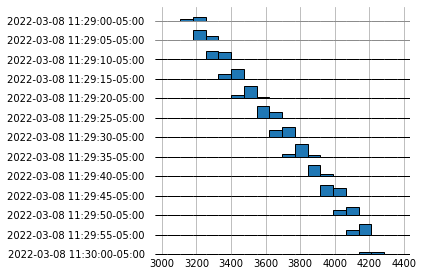

PARAM $2


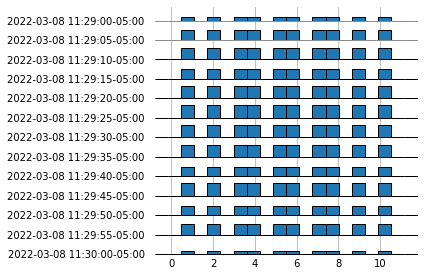

PARAM $3


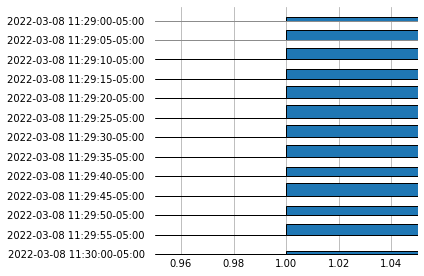

In [15]:
graph_query(0, query_to_df_original_map)

# Transform into Time-Series Data

In [16]:
# Each interval (time step) is vectorized into 4 bins --> [20, 40, 60, 80] percentiles
def left_boundary(x):
  return x.quantile(0.01)
def q1(x):
  return x.quantile(0.1)
def q2(x):
  return x.quantile(0.2)
def q3(x):
  return x.quantile(0.3)
def q4(x):
  return x.quantile(0.4)
def q5(x):
  return x.quantile(0.5)
def q6(x):
  return x.quantile(0.6)
def q7(x):
  return x.quantile(0.7)
def q8(x):
  return x.quantile(0.8)
def q9(x):
  return x.quantile(0.9)
def right_boundary(x):
  return x.quantile(0.99)

# quantiles = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
quantiles = [left_boundary, q1, q2, q3, q4, q5, q6, q7, q8, q9, right_boundary]
quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Prediction interval hyperparameters
prediction_interval = pd.Timedelta("2S") # Each interval has two seconds
prediction_seq_len = 5 # 5 data points
prediction_horizon = pd.Timedelta("2S")
# total time = interval * seq_len

In [205]:
# # X has shape (N, seq_len, num_quantiles) --> each training instance has shape (seq_len, num_quantiles) 
# # Y has shape (N, num_quantiles)
# X, Y = [], []
# for qt, tdfp in tqdm(query_to_df_map.items()):
#   dtypes = query_to_dtype_map[qt]
#   for j, col in enumerate(tdfp):
#     # Skip non-numerical columns
#     if dtypes[j] == "string":
#       continue

#     # Group by time and get quantile data
#     time_series_df = tdfp[col].resample(prediction_interval).agg(quantiles)
#     time_series_df = time_series_df.astype(float)
#     # display(time_series_df.head())
#     shifted = time_series_df.shift(freq=-prediction_horizon).reindex_like(time_series_df).ffill()

#     # Generate training instance. Add padding if neccesary
#     for i in range(len(time_series_df)):
#       if i+1 >= prediction_seq_len:
#         i_start = i - prediction_seq_len + 1
#         X.append(time_series_df.iloc[i_start:(i+1),:].to_numpy())
#         Y.append(time_series_df.iloc[i, :].to_numpy())
#       else:
#         x = time_series_df.iloc[:(i+1),:].to_numpy()
#         # Add padding above the rows
#         x = np.pad(x, ((prediction_seq_len-i-1, 0), (0, 0)))
#         X.append(x)
#         Y.append(time_series_df.iloc[i, :].to_numpy())
# X, Y = np.asarray(X), np.asarray(Y)
# print(X.shape, Y.shape)

100%|██████████| 31/31 [00:42<00:00,  1.37s/it]

(3330, 5, 11) (3330, 11)


In [14]:
# X has shape (N, seq_len, num_quantiles) --> each training instance has shape (seq_len, num_quantiles) 
# Y has shape (N, num_quantiles)
query_to_param_X = {}
query_to_param_Y = {}
for qt, tdfp in tqdm(query_to_df_normalized_map.items()):
  param_X = []
  param_Y = []

  dtypes = query_to_dtype_map[qt]
  for j, col in enumerate(tdfp):
    # Skip non-numerical columns
    if dtypes[j] == "string":
      param_X.append(None)
      param_Y.append(None)
      continue
    
    param_col_X = []
    param_col_Y = []
    # Group by time and get quantile data
    time_series_df = tdfp[col].resample(prediction_interval).agg(quantiles)
    time_series_df = time_series_df.astype(float)
    # display(time_series_df.head())
    shifted = time_series_df.shift(freq=-prediction_horizon).reindex_like(time_series_df).ffill()

    # Generate training instance. Add padding if neccesary
    for i in range(len(time_series_df)):
      if i+1 >= prediction_seq_len:
        i_start = i - prediction_seq_len + 1
        param_col_X.append(time_series_df.iloc[i_start:(i+1),:].to_numpy())
        param_col_Y.append(time_series_df.iloc[i, :].to_numpy())
      else:
        x = time_series_df.iloc[:(i+1),:].to_numpy()
        # Add padding above the rows
        x = np.pad(x, ((prediction_seq_len-i-1, 0), (0, 0)))
        param_col_X.append(x)
        param_col_Y.append(time_series_df.iloc[i, :].to_numpy())
    param_col_X, param_col_Y = np.asarray(param_col_X), np.asarray(param_col_Y)
    param_X.append(param_col_X)
    param_Y.append(param_col_Y)

  query_to_param_X[qt] = param_X
  query_to_param_Y[qt] = param_Y



100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


In [19]:
# np.savez('param_training_data.npz', X=X, Y=Y)
with open('./data/query_to_param_X.pickle', 'wb') as f:
    pickle.dump(query_to_param_X, f)
with open('./data/query_to_param_Y.pickle', 'wb') as f:
    pickle.dump(query_to_param_Y, f)

# Playground

In [ ]:
gdft = gdf['query_params'].apply(literal_eval).apply(pd.Series)
# Remove unneccessary quation marks
gdft = gdft.apply(lambda col: col.str.strip("\"'"))
for col in gdft:
    try:
        gdft[col] = pd.to_datetime(gdft[col], errors='raise')
    except:
        try:
            gdft[col] = pd.to_numeric(gdft[col], errors='raise')
        except:
            pass
gdft = gdft.convert_dtypes()

print(gdft.dtypes)
display(gdft)


In [ ]:
# df = pd.read_csv("parsed_admission/postgres_parsed.csv", parse_dates=["log_time"], index_col=["log_time"])
# empties = df['query_template'] == ''
# print(f"Removing {sum(empties)} empty query template values.")
# df = df[:][~empties]
# print(df.shape)
# df.head()

Removing 0 empty query template values.
(37, 6)


,session_id,session_line_num,virtual_transaction_id,transaction_id,query_template,query_params
log_time,,,,,,
2017-06-25 07:12:57.362167,4811356,0,AAC/4811356/0,NaN,NaN,()
2017-06-25 07:12:57.685996,4811357,0,AAC/4811357/0,NaN,NaN,()
2017-06-25 07:12:57.686190,4811357,1,AAC/4811357/1,NaN,NaN,()
2017-06-25 07:12:57.686832,4811357,2,AAC/4811357/2,NaN,"SELECT expdate,expdate2 FROM systemenv where d...","('1',)"
2017-06-25 07:12:57.695170,4811357,3,AAC/4811357/3,NaN,select content from content where name= $1 and...,"(""'15\\5d3afff71fda95c45e666b77095523a5'"", '1')"


In [97]:


def generate_ar_data(
    n_series: int = 10,
    timesteps: int = 400,
    seasonality: float = 3.0,
    trend: float = 3.0,
    noise: float = 0.1,
    level: float = 1.0,
    exp: bool = False,
    seed: int = 213,
) -> pd.DataFrame:
    """
    Generate multivariate data without covariates.

    Eeach timeseries is generated from seasonality and trend. Important columns:

    * ``series``: series ID
    * ``time_idx``: time index
    * ``value``: target value

    Args:
        n_series (int, optional): Number of series. Defaults to 10.
        timesteps (int, optional): Number of timesteps. Defaults to 400.
        seasonality (float, optional): Normalized frequency, i.e. frequency is ``seasonality / timesteps``.
            Defaults to 3.0.
        trend (float, optional): Trend multiplier (seasonality is multiplied with 1.0). Defaults to 3.0.
        noise (float, optional): Level of gaussian noise. Defaults to 0.1.
        level (float, optional): Level multiplier (level is a constant to be aded to timeseries). Defaults to 1.0.
        exp (bool, optional): If to return exponential of timeseries values. Defaults to False.
        seed (int, optional): Random seed. Defaults to 213.

    Returns:
        pd.DataFrame: data
    """
    # sample parameters
    np.random.seed(seed)
    linear_trends = np.random.normal(size=n_series)[:, None] / timesteps
    quadratic_trends = np.random.normal(size=n_series)[:, None] / timesteps**2
    seasonalities = np.random.normal(size=n_series)[:, None]
    levels = level * np.random.normal(size=n_series)[:, None]

    # generate series
    x = np.arange(timesteps)[None, :]
    print(linear_trends)
    print(x * linear_trends)
    print(seasonalities)
    # y = c*m1 * x + c* m2 * x^2 + m3 * sin(2pi*s*x/400)
    series = (x * linear_trends + x**2 * quadratic_trends) * trend + seasonalities * np.sin(
        2 * np.pi * seasonality * x / timesteps
    )
    # add noise
    series = levels * series * (1 + noise * np.random.normal(size=series.shape))
    if exp:
        series = np.exp(series)

    # insert into dataframe
    data = (
        pd.DataFrame(series)
        .stack()
        .reset_index()
        .rename(columns={"level_0": "series", "level_1": "time_idx", 0: "value"})
    )

    return data

temp = generate_ar_data(n_series=1, timesteps=400)
temp

[[0.00033711]]
[[0.         0.00033711 0.00067423 0.00101134 0.00134845 0.00168557
  0.00202268 0.0023598  0.00269691 0.00303402 0.00337114 0.00370825
  0.00404536 0.00438248 0.00471959 0.00505671 0.00539382 0.00573093
  0.00606805 0.00640516 0.00674227 0.00707939 0.0074165  0.00775361
  0.00809073 0.00842784 0.00876496 0.00910207 0.00943918 0.0097763
  0.01011341 0.01045052 0.01078764 0.01112475 0.01146186 0.01179898
  0.01213609 0.01247321 0.01281032 0.01314743 0.01348455 0.01382166
  0.01415877 0.01449589 0.014833   0.01517012 0.01550723 0.01584434
  0.01618146 0.01651857 0.01685568 0.0171928  0.01752991 0.01786702
  0.01820414 0.01854125 0.01887837 0.01921548 0.01955259 0.01988971
  0.02022682 0.02056393 0.02090105 0.02123816 0.02157527 0.02191239
  0.0222495  0.02258662 0.02292373 0.02326084 0.02359796 0.02393507
  0.02427218 0.0246093  0.02494641 0.02528353 0.02562064 0.02595775
  0.02629487 0.02663198 0.02696909 0.02730621 0.02764332 0.02798043
  0.02831755 0.02865466 0.02899178

,series,time_idx,value
0,0,0,0.000000
1,0,1,0.036709
2,0,2,0.071428
3,0,3,0.111010
4,0,4,0.145110
...,...,...,...
395,0,395,6.924453
396,0,396,6.222408
397,0,397,6.116891
398,0,398,5.736856


0      series  time_idx     value
0         0         0  0.000000
1         0         1  0.036709
2         0         2  0.071428
3         0         3  0.111010
4         0         4  0.145110
..      ...       ...       ...
395       0       395  6.924453
396       0       396  6.222408
397       0       397  6.116891
398       0       398  5.736856
399       0       399  6.366929

[400 rows x 3 columns]


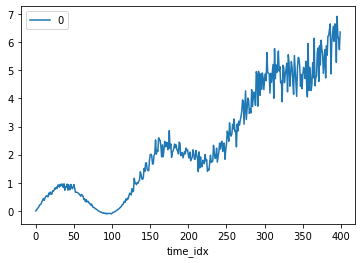

In [98]:
fig, ax = plt.subplots()

for key, grp in temp.groupby(['series']):
  print(key, grp)
  ax = grp.plot(ax=ax, kind='line', x='time_idx', y='value', label=key)